# **Phase Based Motion Amplification**

This notebook shows how Phase Based Motion Amplification is implemented in PyTorch with all image channels. The main purpose of only using a single channel is to understand how the algorithm works and visualize it's different components on each step without getting lost in the implementation aspect. The alogithm is parallelized on GPU via PyTorch and can run in less than 60 seconds as long aas the images are rescaled below 400x400 (the numpy version takes over 5min). 

To ensure a good tradeoff between speed and accuracy, we use 32 bit floats and 64 bit complex data types.

## **Algorithm**

0. Obtain Video Frames and set Hyperparameters 
1. Get Filters for Complex Steerable Pyramid Decomposition
2. Compute and Store DFT for entire Video Sequence, create results data structure of same shape
3. For each Pyramid Filter level (except hi and lo pass):
    - Compute Reference Pyramid Decomposition and Reference Phase
    - For each video frame:
        - Compute current Pyramid Decomposition and store in data structure
        - Compute Phase Delta (current - reference) and store in data structure
    - Temporally Filter Phase Deltas with bandpass at desired frequency
    - // Apply Motion Magnification to each Frame 
    - For each video frame:
        - Get Current (filtered) Phase Delta and pyramid decomposition
        - Perform Amplitude Weighted Blurring
        - Modify (increase or decrease) phase variation
        - Attenuate unwanted frequencies
        - Apply modified phase to current pyramid decomposition
        - Accumulate reconstructed pyramid levels in results data structure
4. Add hi and lo pass components to results
5. Compute the Inverse DFT for each frame

In [1]:
import numpy as np
import cv2
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from steerable_pyramid import SteerablePyramid, SuboctaveSP
from phase_utils import *
from pyramid_utils import build_level, build_level_batch, recon_level_batch

%matplotlib inline

### Obtain Video

In [2]:
video_path = "videos/crane_crop.avi"
# video_path = "videos/crane.avi"

#### Resize Frames to preserve memory

In [3]:
scale_factor = 0.75

In [4]:
bgr_frames = []
frames = [] # frames for processing
cap = cv2.VideoCapture(video_path)

# video sampling rate
fs = cap.get(cv2.CAP_PROP_FPS)

idx = 0

while(cap.isOpened()):
    ret, frame = cap.read()
    # if frame is read correctly ret is True
    if not ret:
        break

    if idx == 0:
        og_h, og_w, _ = frame.shape
        w = int(og_w*scale_factor)
        h = int(og_h*scale_factor)

    # store original frames
    bgr_frames.append(frame)

    # get normalized YIQ frame
    rgb = np.float32(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)/255)
    yiq = rgb2yiq(rgb)

    # append resized Luma channel 
    frames.append(cv2.resize(yiq[:, :, 0], (w, h)))

    idx += 1
    
    
cap.release()
cv2.destroyAllWindows()
del cap

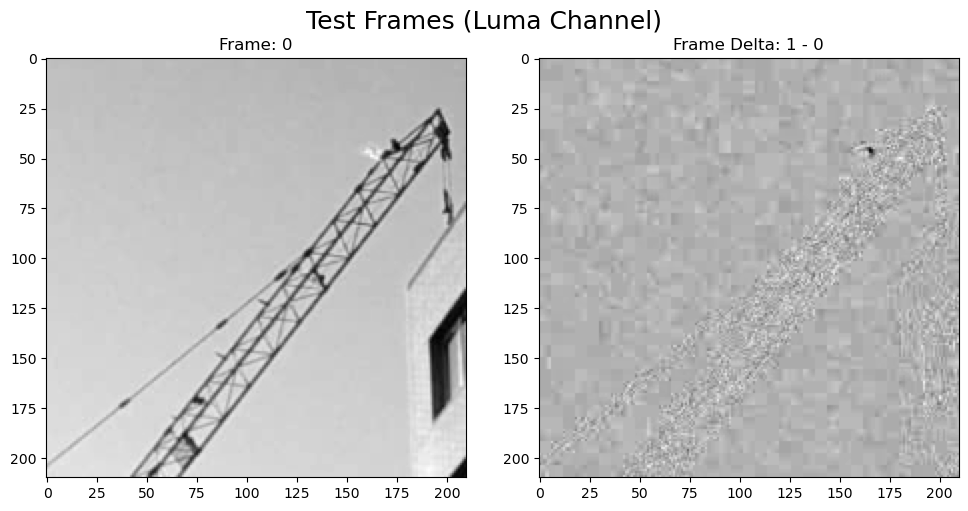

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Test Frames (Luma Channel)", size=18)
ax[0].imshow(frames[0], cmap='gray')
ax[0].set_title("Frame: 0")
ax[1].imshow(np.float32(frames[1]) - np.float32(frames[0]), cmap='gray');
ax[1].set_title("Frame Delta: 1 - 0")

plt.tight_layout();

## **0. Set Hyperparameters**

In [6]:
# use first frame as the reference frame
ref_idx = 0
ref_frame = frames[ref_idx]
h, w = ref_frame.shape

# video length
num_frames = len(frames)

# factor to avoid division by 0
eps = 1e-6

# CUDA Parallelization
batch_size = 2 
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
# Bandpass Filter Frequencies
f_lo = 0.2 
f_hi = 0.25 

# weighted amplitude blur parameters
sigma = 5.0 

# attenuate other frequencies
attenuate = True

# phase magnification factor
phase_mag = 25.0

#### Get Gaussian Kernel for Amplitude weighted Blurring

In [8]:
# ensure ksize is odd or the filtering will take too long
# see warning in: https://pytorch.org/docs/stable/generated/torch.nn.functional.conv2d.html
ksize = np.max((3, np.ceil(4*sigma) - 1)).astype(int)
if ((ksize % 2) != 1):
    ksize += 1

# get Gaussian Blur Kernel for reference only
gk = cv2.getGaussianKernel(ksize=ksize, sigma=sigma)
gauss_kernel = torch.tensor(gk @ gk.T).type(torch.float32) \
                                      .to(device) \
                                      .unsqueeze(0) \
                                      .unsqueeze(0)

In [9]:
# check that the Gaussian Kernel dimensions are odd
gauss_kernel.shape

torch.Size([1, 1, 19, 19])

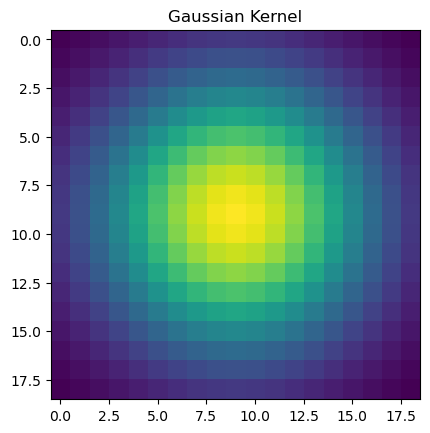

In [10]:
plt.imshow(gk @ gk.T);
plt.title("Gaussian Kernel");

### **Get Temporal Filter**


Dividing the frequencies by the sample rate normalizes to [0–0.5] and scaling by 2 normalizes them to [0–1]. Our scipy function expects this by default, but we can alternatively pass in the sampling rate fs along with our raw frequencies.

In [11]:
from scipy import signal

# normalize freqeuncies to the Nyquist rate
norm_f_lo = f_lo / fs * 2
norm_f_hi = f_hi / fs * 2

# Get Bandpass Impulse Response
bandpass = signal.firwin(numtaps=len(frames), 
                         cutoff=[norm_f_lo, norm_f_hi], 
                         pass_zero=False)

# we also pass unnormalized freqeuncies as long as we include the sample rate fs
# bandpass = signal.firwin(numtaps=len(frames), 
#                          cutoff=[f_lo, f_hi], 
#                          pass_zero=False,
#                          fs=fs)

# Get Frequency Domain Transfer Function
transfer_function = torch.fft.fft(
    torch.fft.ifftshift(torch.tensor(bandpass))).to(device) \
                                                .type(torch.complex64)
transfer_function = torch.tile(transfer_function, 
                               [1, 1, 1, 1]).permute(0, 3, 1, 2)

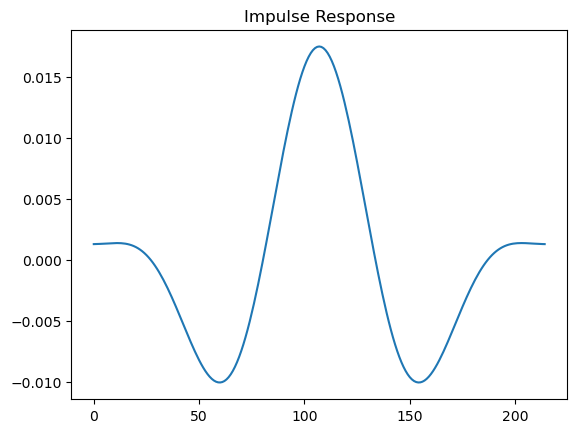

In [12]:
plt.plot(bandpass)
plt.title("Impulse Response");

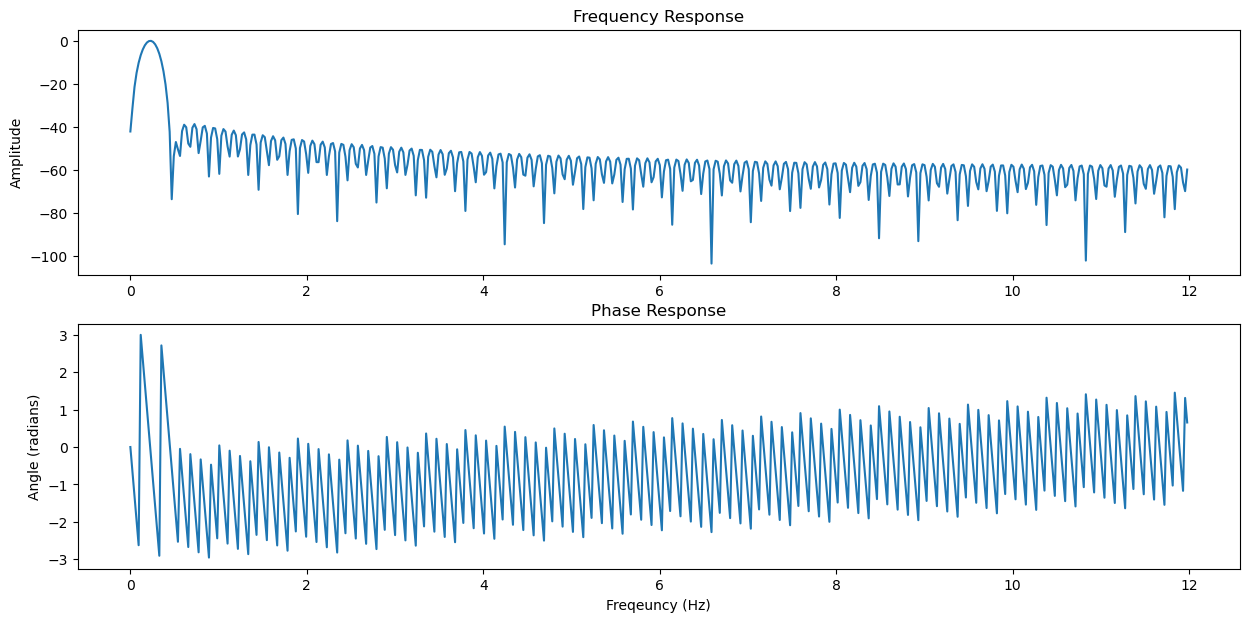

In [13]:
norm_freqs, response = signal.freqz(bandpass)
freqs = norm_freqs / np.pi * fs/ 2 

_, ax = plt.subplots(2, 1, figsize=(15, 7))
ax[0].plot(freqs, 20*np.log10(np.abs(response)));
ax[0].set_title("Frequency Response");
ax[0].set_ylabel("Amplitude");

ax[1].plot(freqs, np.angle(response));
ax[1].set_title("Phase Response");
ax[1].set_xlabel("Freqeuncy (Hz)");
ax[1].set_ylabel("Angle (radians)");

## **1. Get CSP Filters**

Try out different Steerable Pyramid options

In [14]:
max_depth = int(np.floor(np.log2(np.min(np.array(ref_frame.shape)))) - 2)

# Regular Pyramids with SubOctave Filter Scaling
# csp = SteerablePyramid(depth=max_depth, orientations=4, filters_per_octave=1, twidth=1.0, complex_pyr=True)
csp = SteerablePyramid(depth=max_depth, orientations=8, filters_per_octave=2, twidth=0.75, complex_pyr=True)
# csp = SteerablePyramid(depth=max_depth, orientations=8, filters_per_octave=2, twidth=0.25, complex_pyr=True)

# SubOctave Pyramids
# csp = SuboctaveSP(depth=max_depth-1, orientations=8, filters_per_octave=2, cos_order=6, complex_pyr=True) 
# csp = SuboctaveSP(depth=max_depth, orientations=8, filters_per_octave=4, cos_order=6, complex_pyr=True) 

filters, crops = csp.get_filters(h, w, cropped=False)

print(f"Number of Pyramid Filters: {len(filters)}")

Number of Pyramid Filters: 82


## Display Freqeuncy Partition of Oriented Sub-Band Filters

In [15]:
filter_partition = np.dstack(filters[1:-1]).sum(axis=-1)

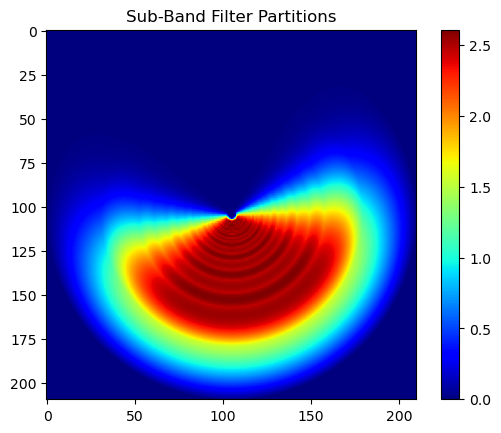

In [16]:
plt.imshow(filter_partition, cmap='jet');
plt.title("Sub-Band Filter Partitions");
plt.colorbar();

In [17]:
import matplotlib as mpl
from matplotlib import cm

cmap = cm.get_cmap('gist_rainbow', len(filters) - 2) # old way 
# cmap = mpl.colormaps.get_cmap('gist_rainbow')    # new way which is not as good :(

C:\Users\itber\AppData\Local\Temp\ipykernel_51804\2412529402.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('gist_rainbow', len(filters) - 2) # old way


In [18]:
color_filter_partition = np.zeros_like(filter_partition[:, :, None].repeat(3, axis=2))

for i in range(1, len(filters[1:-1])):
    # scramble the colors!
    tmp_filt = filters[i][:, :, None].repeat(3, axis=2) * np.array(cmap(i)[:3])

    # scramble the colors!
    # blue = int(i*30 % 256)/255
    # green = int(i*103 % 256)/255
    # red = int(i*50 % 256)/255

    # tmp_filt = filters[i][:, :, None].repeat(3, axis=2) * 2*np.array([red, blue, green])
    
    color_filter_partition += tmp_filt/3

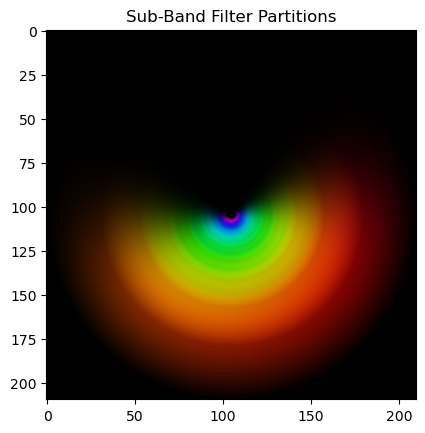

In [19]:
plt.imshow(color_filter_partition)
plt.title("Sub-Band Filter Partitions");

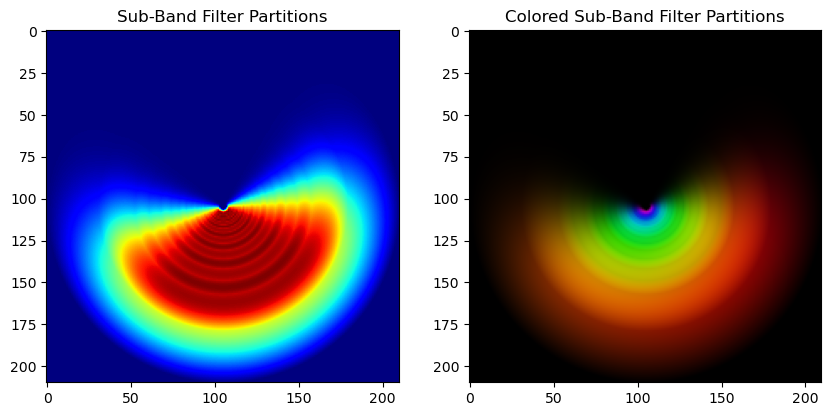

In [20]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(filter_partition, cmap='jet')
ax[0].set_title("Sub-Band Filter Partitions")

ax[1].imshow(color_filter_partition)
ax[1].set_title("Colored Sub-Band Filter Partitions");

Get Filters Tensor

In [21]:
filters_tensor = torch.tensor(np.array(filters)).type(torch.float32).to(device)

## **2. Compute DFT for each frame of the video**

In [22]:
## Get DFT of all video frames
frames_tensor = torch.tensor(np.array(frames)).type(torch.float32).to(device)
video_dft = torch.fft.fftshift(torch.fft.fft2(frames_tensor, dim=(1,2))).type(torch.complex64).to(device)

In [23]:
recon_dft = torch.zeros((len(frames), h, w), dtype=torch.complex64).to(device)

#### Setup filter2D for PyTorch with circular padding

The Torch Functional implementation of conv2d does not have the option for circular padding! But it seems like this approach takes longer, more than twice as long! :(

In [24]:
import torch.nn as nn

filter2D = nn.Conv2d(in_channels=1, out_channels=1,
                     kernel_size=gauss_kernel.shape[2:], 
                     padding='same',
                     padding_mode='circular',
                     groups=1, 
                     bias=False)

filter2D.weight.data = gauss_kernel
filter2D.weight.requires_grad = False

## **3. For each Pyramid Level**

In [25]:
phase_deltas = torch.zeros((batch_size, len(frames), h, w), dtype=torch.complex64).to(device)

for level in range(1, len(filters) - 1, batch_size):

    # get batch indices
    idx1 = level
    idx2 = level + batch_size

    # get current filter batch
    filter_batch = filters_tensor[idx1:idx2]

    ## get reference frame pyramid and phase (DC)
    ref_pyr = build_level_batch(video_dft[ref_idx, :, :].unsqueeze(0), filter_batch)
    ref_phase = torch.angle(ref_pyr)

    ## Get Phase Deltas for each frame
    for vid_idx in range(num_frames):

        curr_pyr = build_level_batch(
                    video_dft[vid_idx, :, :].unsqueeze(0), filter_batch)

        # unwrapped phase delta
        _delta = torch.angle(curr_pyr) - ref_phase 

        # get phase delta wrapped to [-pi, pi]
        phase_deltas[:, vid_idx, :, :] = ((torch.pi + _delta) \
                                            % 2*torch.pi) - torch.pi
    
    ## Temporally Filter the phase deltas
    # Filter in Frequency Domain and convert back to phase space
    phase_deltas = torch.fft.ifft(transfer_function \
                                  * torch.fft.fft(phase_deltas, dim=1),  
                                  dim=1).real

    ## Apply Motion Magnifications
    for vid_idx in range(num_frames):

        curr_pyr = build_level_batch(video_dft[vid_idx, :, :].unsqueeze(0), filter_batch)
        delta = phase_deltas[:, vid_idx, :, :]

        ## Perform Amplitude Weighted Blurring
        if sigma != 0:
            amplitude_weight = torch.abs(curr_pyr) + eps
            
            # Torch Functional Approach (faster)
            weight = F.conv2d(input=amplitude_weight.unsqueeze(1), 
                              weight=gauss_kernel, 
                              padding='same').squeeze(1)
            
            delta = F.conv2d(input=(amplitude_weight * delta).unsqueeze(1), 
                              weight=gauss_kernel, 
                              padding='same').squeeze(1) 

            # Torch nn approach with circular padding
            # weight = filter2D(amplitude_weight.unsqueeze(1)).squeeze(1)
            # delta = filter2D((amplitude_weight * delta).unsqueeze(1)).squeeze(1)
            
            # get weighted Phase Deltas
            delta /= weight

        ## Modify phase variation
        modifed_phase = delta * phase_mag

        ## Attenuate other frequencies by scaling magnitude by reference phase
        if attenuate:
            curr_pyr = torch.abs(curr_pyr) * (ref_pyr/torch.abs(ref_pyr)) 


        ## apply modified phase to current level pyramid decomposition
        # if modified_phase = 0, then no change!
        curr_pyr = curr_pyr * torch.exp(1.0j*modifed_phase) # ensures correct type casting

        ## accumulate reconstruced levels
        recon_dft[vid_idx, :, :] += recon_level_batch(curr_pyr, filter_batch).sum(dim=0)

Note on attenuating unwanted frequencies

In the vanilla implemntation, we add the motion magnified phase delta to the complex filter decomposition. This takes the current phase and adds in the additional motion amplification. When we attenate other frequencies, we are adding the delta phase to the magnitude of the filter decomposition. Taking the magnitude of the filter decomposition removes all phase components, inserting the phase delta provides motion information for only the frequency bands that we are interested in (as filtered by the temporal bandpass filter)

## **4. Add Hi and Lo Components to the reconstructed DFT**

In [26]:
# adding hipass component seems to cause bad artifacts and leaving
# it out doesn't seem to impact the overall quality
hipass = filters_tensor[0]
lopass = filters_tensor[-1]

## add back lo and hi pass components
for vid_idx in range(num_frames):
    # accumulate Lo Pass Components
    curr_pyr_lo = build_level(video_dft[vid_idx, :, :], lopass)
    dft_lo = torch.fft.fftshift(torch.fft.fft2(curr_pyr_lo))
    recon_dft[vid_idx, :, :] += dft_lo*lopass

    # OPTIONAL accumulate Lo Pass Components
    curr_pyr_hi = build_level(video_dft[vid_idx, :, :], hipass)
    dft_hi = torch.fft.fftshift(torch.fft.fft2(curr_pyr_hi)) 
    recon_dft[vid_idx, :, :] += dft_hi*hipass

Check DFT Magnitude

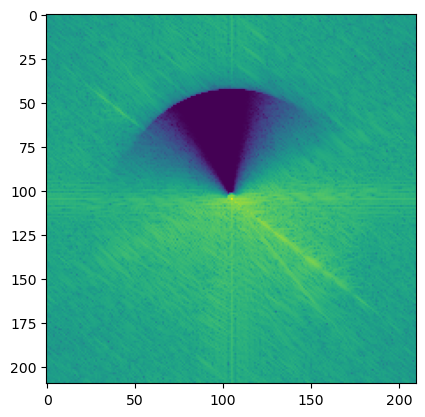

In [28]:
plt.imshow(np.log(np.abs(recon_dft[10, :, :].cpu()) + 1e-6));

## **5. Get Inverse DFT of entire results DFT**

In [29]:
result_video = torch.fft.ifft2(torch.fft.ifftshift(recon_dft, dim=(1,2)), dim=(1,2)).real

In [30]:
# remove from CUDA
result_video = result_video.cpu()

Observe reconstruction error

In [33]:
print(torch.sum(torch.abs(frames_tensor[0, :, :].cpu() - result_video[0, :, :])),
      torch.mean(torch.square(frames_tensor[0, :, :].cpu() - result_video[0, :, :]).float()))

tensor(770.1630) tensor(0.0017)


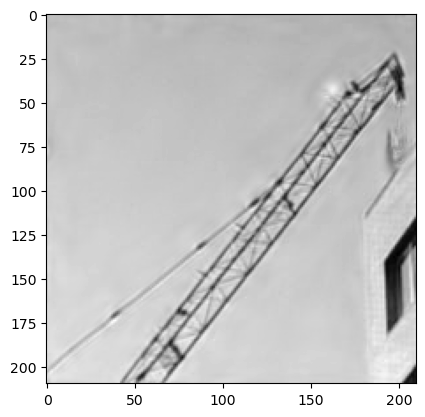

In [34]:
plt.imshow(result_video[0, :, :], cmap='gray');

In [35]:
rgb_modified = []

for vid_idx in range(num_frames):
    # get current OG YIQ frame and resized result Luma Frame
    rgb = np.float32(cv2.cvtColor(bgr_frames[vid_idx], cv2.COLOR_BGR2RGB)/255)
    yiq_frame = rgb2yiq(rgb)

    result_frame = cv2.resize(result_video[vid_idx, :, :].numpy(), (og_w, og_h))

    # modify YIQ frame
    yiq_frame[:, :, 0] = result_frame

    # convert to rgb
    rgb_frame = yiq2rgb(yiq_frame)

    # normalize
    rgb_frame = cv2.convertScaleAbs(rgb_frame, alpha=255, beta=0)

    rgb_modified.append(rgb_frame)

## **Make Video of Results**

In [36]:
stacked_frames = []
middle = np.zeros((og_h, 3, 3)).astype(np.uint8)

for vid_idx in range(len(frames)):
    frame = np.hstack((bgr_frames[vid_idx], 
                       middle, 
                       cv2.cvtColor(rgb_modified[vid_idx], cv2.COLOR_RGB2BGR)))
    stacked_frames.append(frame)

In [37]:
stacked_frames[0].shape

(280, 563, 3)

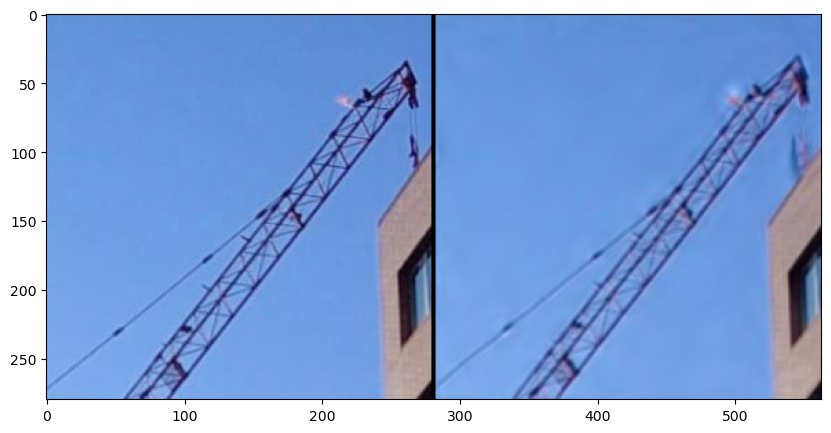

In [38]:
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(stacked_frames[-1], cv2.COLOR_BGR2RGB));

In [39]:
# get width and height for video frames
_h, _w, _ = stacked_frames[-1].shape

# save to mp4
out = cv2.VideoWriter(f"videos/crane_stacked_{int(phase_mag)}x.mp4",
                      cv2.VideoWriter_fourcc(*'MP4V'), 
                      int(fs), 
                      (_w, _h))
 
for frame in stacked_frames:
    out.write(frame)

out.release()
del out